<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snowmelt_prediction_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install hydroeval

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hydroeval as he
# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [30]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab_Notebooks/Dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [31]:
features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [32]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [33]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-33-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T
0,2001-01-01,2.69,345.815123,-4.169740
1,2001-01-02,2.53,343.608727,-4.142604
2,2001-01-03,2.53,341.437417,-5.148725
3,2001-01-04,2.43,339.336277,-6.523695
4,2001-01-05,2.53,337.340394,-6.860106
...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230
4013,2012-12-27,2.91,219.264614,-5.501225
4014,2012-12-28,3.03,210.043412,-5.526874
4015,2012-12-29,2.97,201.080703,-5.107484


In [34]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_snow_melting[['Q','SCA', 'T']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

# Assuming df_snow_melting is your DataFrame
columns_to_scale = ['Q', 'SCA', 'T']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)


             Q       SCA         T
0     0.087577  0.851791  0.302737
1     0.080424  0.844592  0.304062
2     0.080424  0.837508  0.254949
3     0.075953  0.830653  0.187831
4     0.080424  0.824141  0.171409
...        ...       ...       ...
4012  0.097412  0.469406  0.230419
4013  0.097412  0.438898  0.237742
4014  0.102776  0.408812  0.236490
4015  0.100094  0.379570  0.256962
4016  0.097412  0.351593  0.261586

[4017 rows x 3 columns]


In [35]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [36]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers


In [37]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model


In [38]:
input_shape = X.shape[1:]
input_shape

(2, 3)

In [41]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

# Define your input shape
input_shape = X.shape[1:]


# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'

        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        # tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)  # Adjust epochs as needed

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_squared_error(y_val, y_pred)

         # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


Reloading Tuner from /content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_0_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ac67a83eaa0>
Epoch 1/100
67/67 [==============================] - 4s 22ms/step - loss: 0.0437 - mae: 0.1477 - root_mean_squared_error: 0.2090 - val_loss: 0.0201 - val_mae: 0.1025 - val_root_mean_squared_error: 0.1418
Epoch 2/100
67/67 [==============================] - 1s 11ms/step - loss: 0.0134 - mae: 0.0833 - root_mean_squared_error: 0.1158 - val_loss: 0.0049 - val_mae: 0.0526 - val_root_mean_squared_error: 0.0698
Epoch 3/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0097 - mae: 0.0714 - root_mean_squared_error: 0.0987 - val_loss: 0.0067 - val_mae: 0.0645 - val_root_mean_squared_error: 0.0820
Epoch 4/100
67/67 [==============================] - 1s 16ms/step - loss: 0.0092 - mae: 0.0681 - root_mean_squared_error: 0.0959 - val_loss: 0.0093 - v

#  for 4 input

In [25]:

print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Worst Model']['MSE']}, R^2: {scores['Worst Model']['R^2']}, RMSE: {scores['Worst Model']['RMSE']}, MAE: {scores['Worst Model']['MAE']}, kge: {scores['Worst Model']['kge']}, nse: {scores['Worst Model']['nse']}, time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Worst Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Worst Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Worst Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Worst Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Worst Model']['kge'] for scores in nested_scores]
all_nse = [scores['Worst Model']['nse'] for scores in nested_scores]
all_time = [scores['Worst Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.00548535218964157, R^2: 0.9073216350252311, RMSE: 0.0740631635135954, MAE: 0.05610196202706786, kge: [0.81559592], nse: [0.90732164], time: 0.42747974395751953

Fold 2 - MSE: 0.005329437406961141, R^2: 0.9080496585959849, RMSE: 0.07300299587661552, MAE: 0.055760519230525114, kge: [0.82648517], nse: [0.90804966], time: 0.3543720245361328

Fold 3 - MSE: 0.006635970832352008, R^2: 0.8836973888072619, RMSE: 0.0814614683905956, MAE: 0.06095165013817377, kge: [0.82579529], nse: [0.88369739], time: 0.3359692096710205

Fold 4 - MSE: 0.005092080577041893, R^2: 0.9174413043599761, RMSE: 0.07135881569254, MAE: 0.054617837677820406, kge: [0.82620058], nse: [0.9174413], time: 0.4210638999938965

Fold 5 - MSE: 0.004885503438705239, R^2: 0.9167348808879617, RMSE: 0.06989637643472828, MAE: 0.05281062082972997, kge: [0.83471674], nse: [0.91673488], time: 0.5420198440551758
Mean MSE: 0.005
Mean MAE: 0.056
Mean RMSE: 0.074
Mean R^2: 0.907
Mean kge: 0.826
M

In [16]:

# # After the nested cross-validation, you can analyze and compare the results for different folds
# for fold, scores in enumerate(nested_scores):
#     print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Mean MSE: 0.001
Mean MAE: 0.016
Mean RMSE: 0.026
Mean R^2: 0.988
Mean kge: 0.978
Mean nse: 0.988
Mean time: 0.416


126/126 [==============================] - 0s 2ms/step


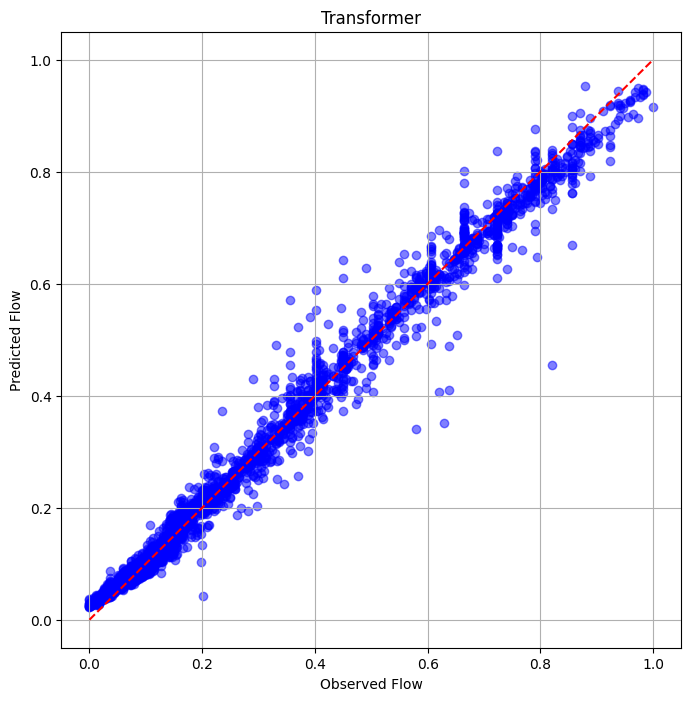

In [19]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


In [20]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/best_model_transformer_4i.h5')


In [21]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.004428728949278593


In [22]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_60: 0.41334630069916445
dropout_61: 0.41334630069916445
dropout_62: 0.108512469730255
dropout_63: 0.108512469730255
dropout_64: 0.21951765260893089
dropout_65: 0.46032819940741143


In [23]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 2, 'head_size': 136, 'num_heads': 2, 'ff_dim': 22, 'dropout_0': 0.41334630069916445, 'dropout_1': 0.108512469730255, 'num_mlp_layers': 2, 'mlp_units_0': 192, 'mlp_dropout_0': 0.21951765260893089, 'optimizer': 'adam', 'learning_rate': 0.004428728929594218, 'dropout_2': 0.11247888387013175, 'dropout_3': 0.5860293116751504, 'dropout_4': 0.3236663952432144, 'dropout_5': 0.45359332283565845, 'dropout_6': 0.5329891003542448, 'dropout_7': 0.47321661969824136, 'mlp_units_1': 160, 'mlp_dropout_1': 0.46032819940741143}
Worst Hyperparameters: {'num_transformer_blocks': 4, 'head_size': 200, 'num_heads': 8, 'ff_dim': 27, 'dropout_0': 0.5109967671147837, 'dropout_1': 0.1445718841056193, 'num_mlp_layers': 1, 'mlp_units_0': 64, 'mlp_dropout_0': 0.10642646933338737, 'optimizer': 'adam', 'learning_rate': 0.0026968200847442554, 'dropout_2': 0.45636149208055465, 'dropout_3': 0.5631346763992136, 'dropout_4': 0.27068232380597756, 'dropout_5': 0.37846376378513

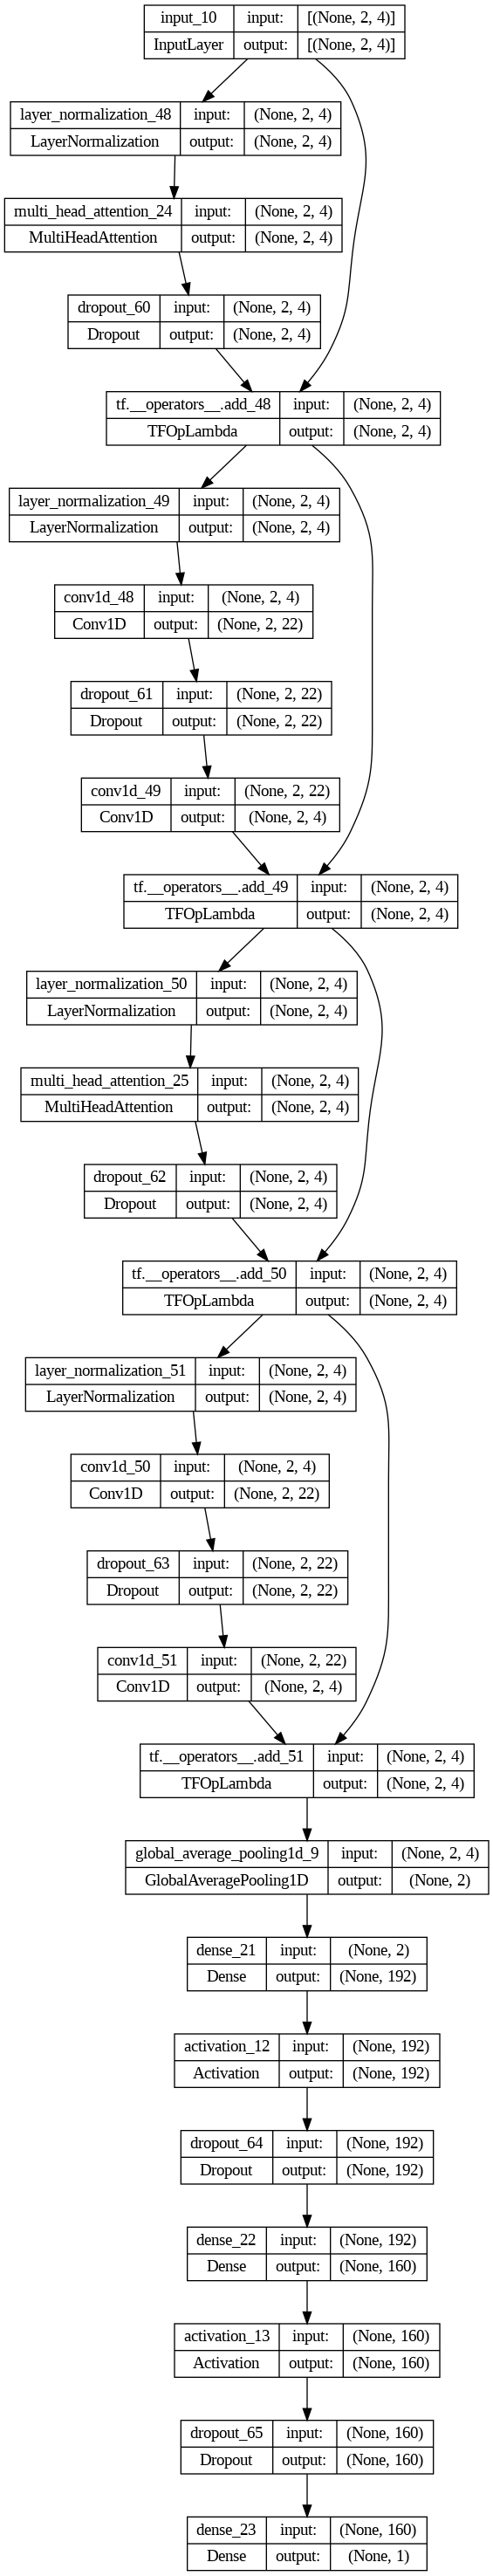

In [24]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True)

# for 3 input value

In [42]:

# # After the nested cross-validation, you can analyze and compare the results for different folds
# for fold, scores in enumerate(nested_scores):
#     print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")


# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Mean MSE: 0.001
Mean MAE: 0.015
Mean RMSE: 0.026
Mean R^2: 0.989
Mean kge: 0.977
Mean nse: 0.989
Mean time: 0.597


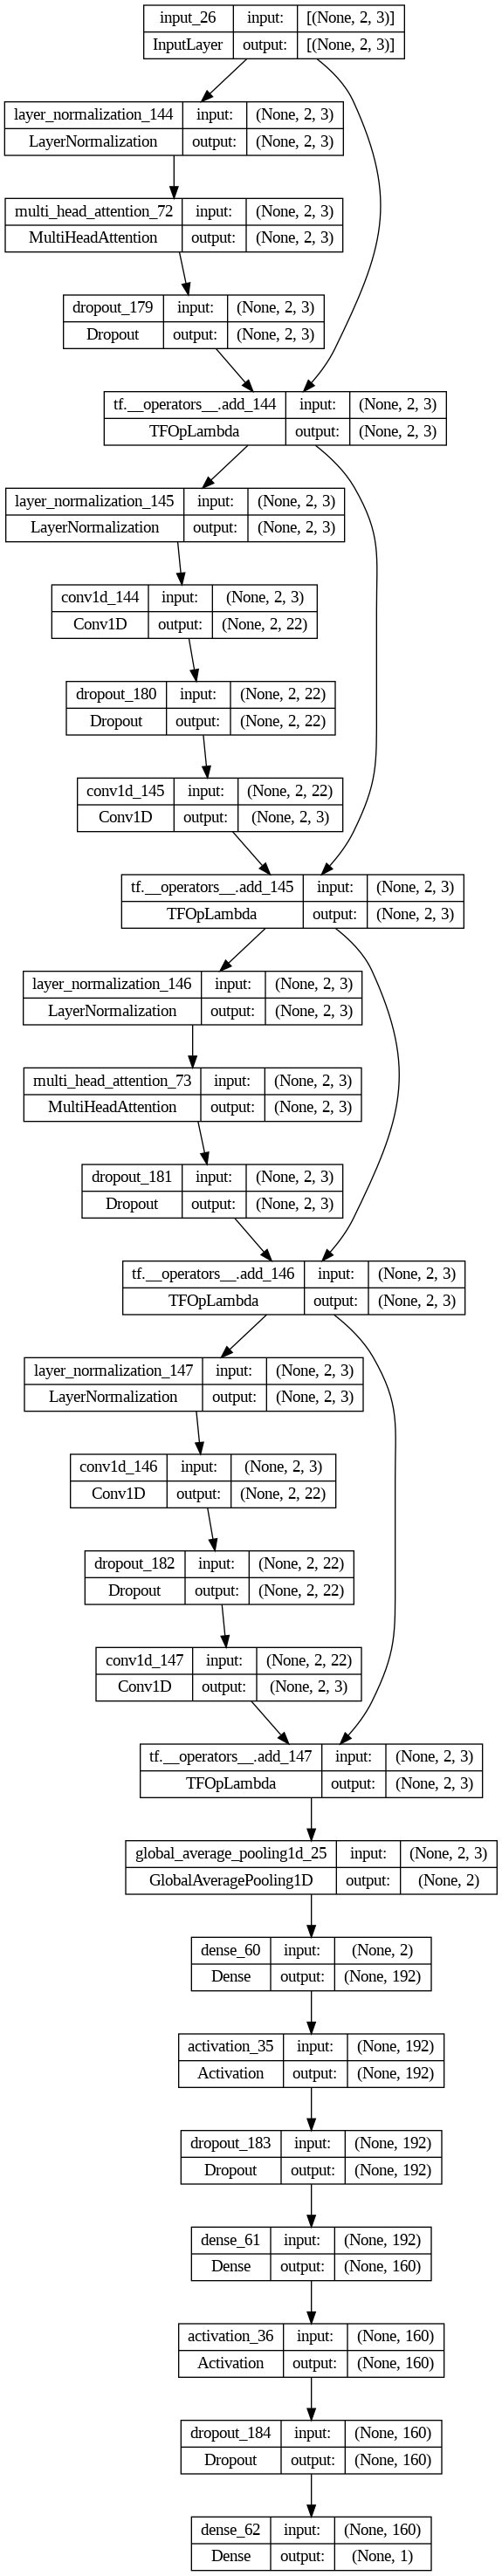

In [43]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True)

In [44]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_179: 0.41334630069916445
dropout_180: 0.41334630069916445
dropout_181: 0.108512469730255
dropout_182: 0.108512469730255
dropout_183: 0.21951765260893089
dropout_184: 0.46032819940741143


In [45]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.004428728949278593


In [46]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/best_model_transformer.h5')


126/126 [==============================] - 0s 3ms/step


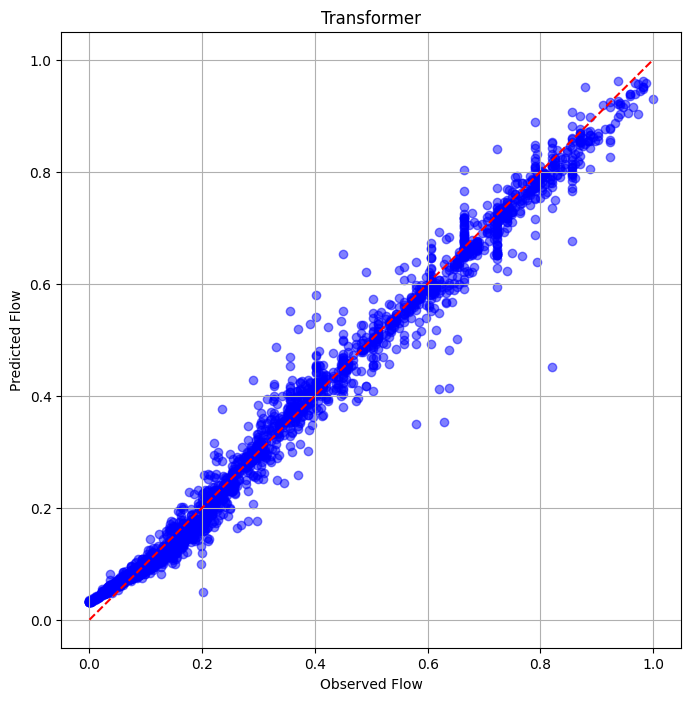

In [47]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()
